In [3]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
%config InlineBackend.figure_format = "retina"
os.chdir("..")

In [4]:
os.getcwd()

'/Volumes/shared/Molekylär Neurobiologi/Castelo-Branco/Mukund/CZI_ADULT/CZI_ATAC'

In [5]:
RESULTS_FILE = "data/P20057_1005/Binned_5kb_count_K27me3_results.h5ad"
BINS_PATH = "bin/5kb_binned_hg38.bed"
FRAG_PATH = "../../../NGSDATA/scATAC_human_adult_CZI_2/Processed_data/cellranger_output/P20057_1005/outs/fragments.tsv.gz"
CSV_PATH = "data/P20057_1005/MK_pre_singlecell_EPI.csv"

In [6]:
annot = epi.ct.load_features(BINS_PATH)

In [7]:
counts = epi.ct.bld_mtx_fly(tsv_file = FRAG_PATH,
                            csv_file = CSV_PATH,
                           annotation = annot,
                           save = "data/P20057_1005/binned_5kb_count_matrix_K27me3.h5ad")

loading barcodes


  0%|          | 0/617665 [00:00<?, ?it/s]

building count matrix


100%|██████████| 617665/617665 [12:59<00:00, 792.41it/s]  


building AnnData object
filtering barcodes


In [8]:
adata = ad.read("data/P20057_1005/binned_5kb_count_matrix_K27me3.h5ad")

In [10]:
adata.raw = adata

In [13]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [15]:
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]

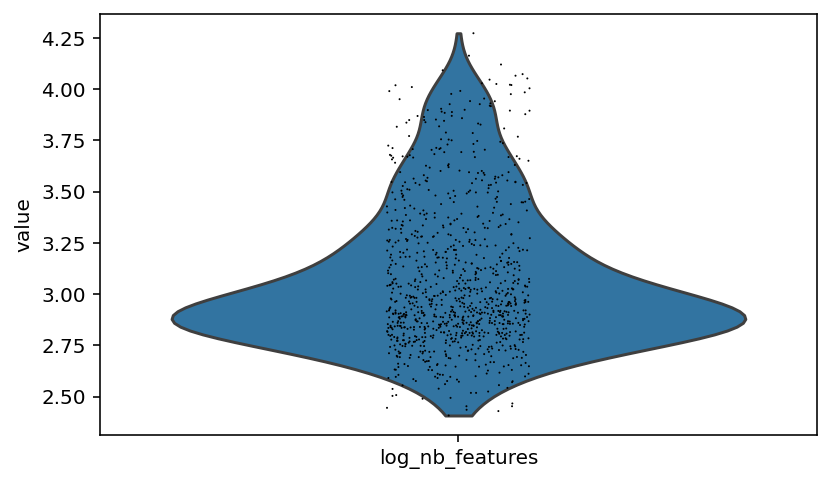

In [16]:
epi.pl.violin(adata, ["log_nb_features"])

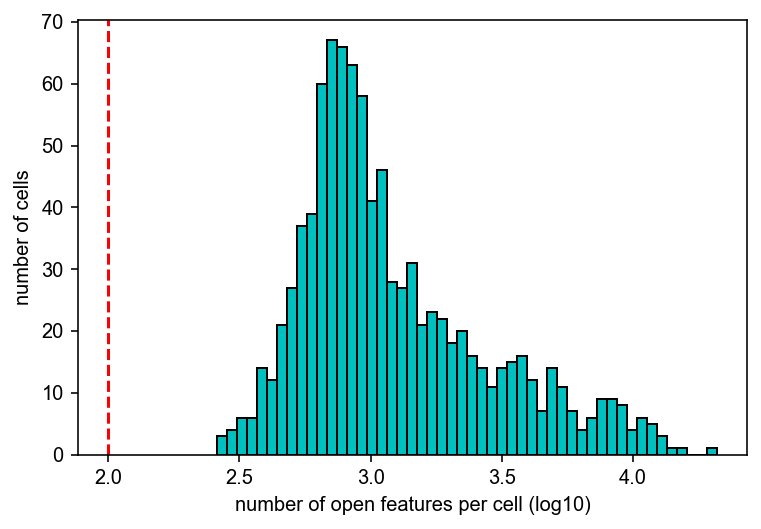

In [17]:
#minimum features to keep 
min_features = 100

epi.pp.coverage_cells(adata,binary=True,log=10,bins=50,
                     threshold=min_features)

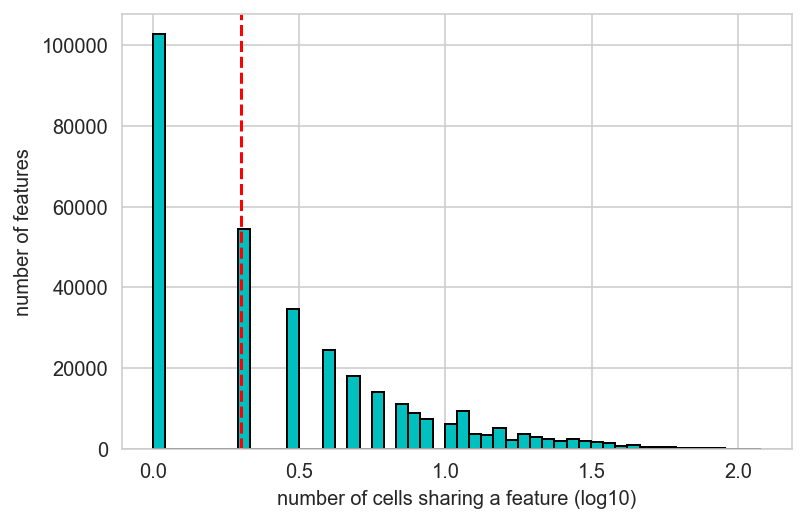

In [19]:
# minimum cells sharing a feature
min_cells = 2
epi.pp.coverage_features(adata, binary=True,log=True,
                        threshold=min_cells)

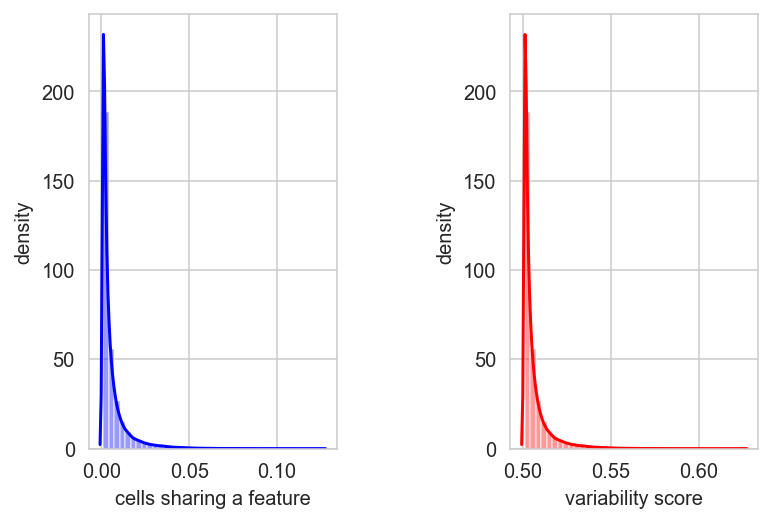

In [20]:
epi.pp.cal_var(adata)

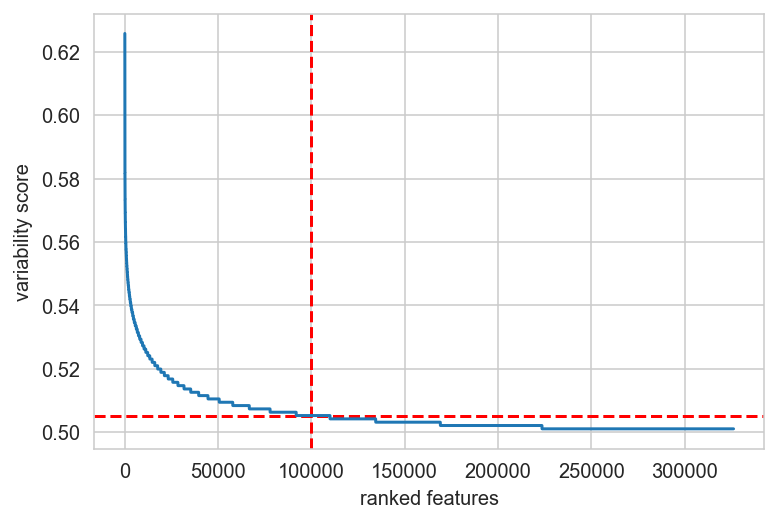

In [22]:
min_score_value = 0.505
nb_feature_selected = 100000

epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

In [23]:
adata = epi.pp.select_var_feature(adata,
                                 nb_features=nb_feature_selected,
                                 show = False,
                                 copy=True)

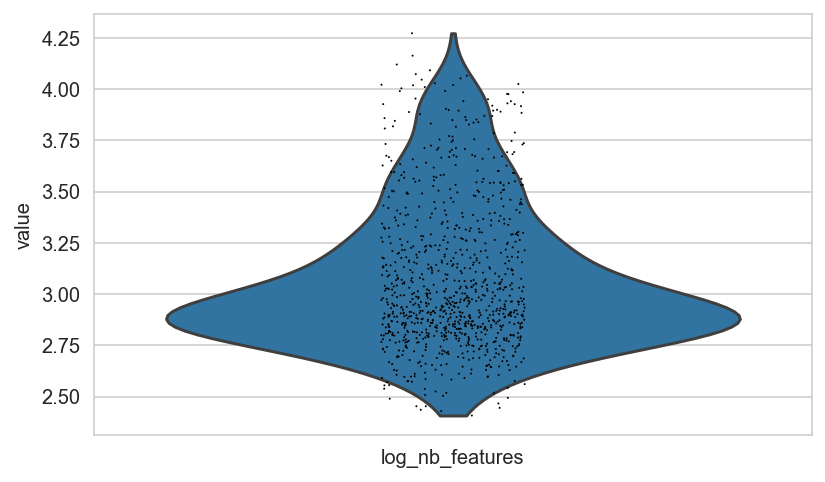

In [25]:
epi.pl.violin(adata, ['log_nb_features'])

In [38]:
np.max(adata.X)
epi.tl.pca(adata, zero_center = False, svd_solver = "arpack")

In [36]:
epi.pp.binarize(adata)

adata_MK_norm = adata

def TFIDF(x):
    tf_x = np.divide(x, x.sum(0))
    idf_x = np.diag(np.log(1 + (np.shape(x)[1]) / x.sum(1)))
    tfidf_x = np.dot(tf_x.T, idf_x).T
    return tfidf_x

X = adata.X.T  #transpose anndata matrix to get cells as columns
tfidf_X = TFIDF(X.toarray())  # convert to nparray and run TF-IDF

#convert back to scipy.sparse and transpose to get cells as rows
adata_MK_norm.X = scipy.sparse.csr_matrix(tfidf_X).T

adata.layers["MK_normalized"] = adata_MK_norm.X

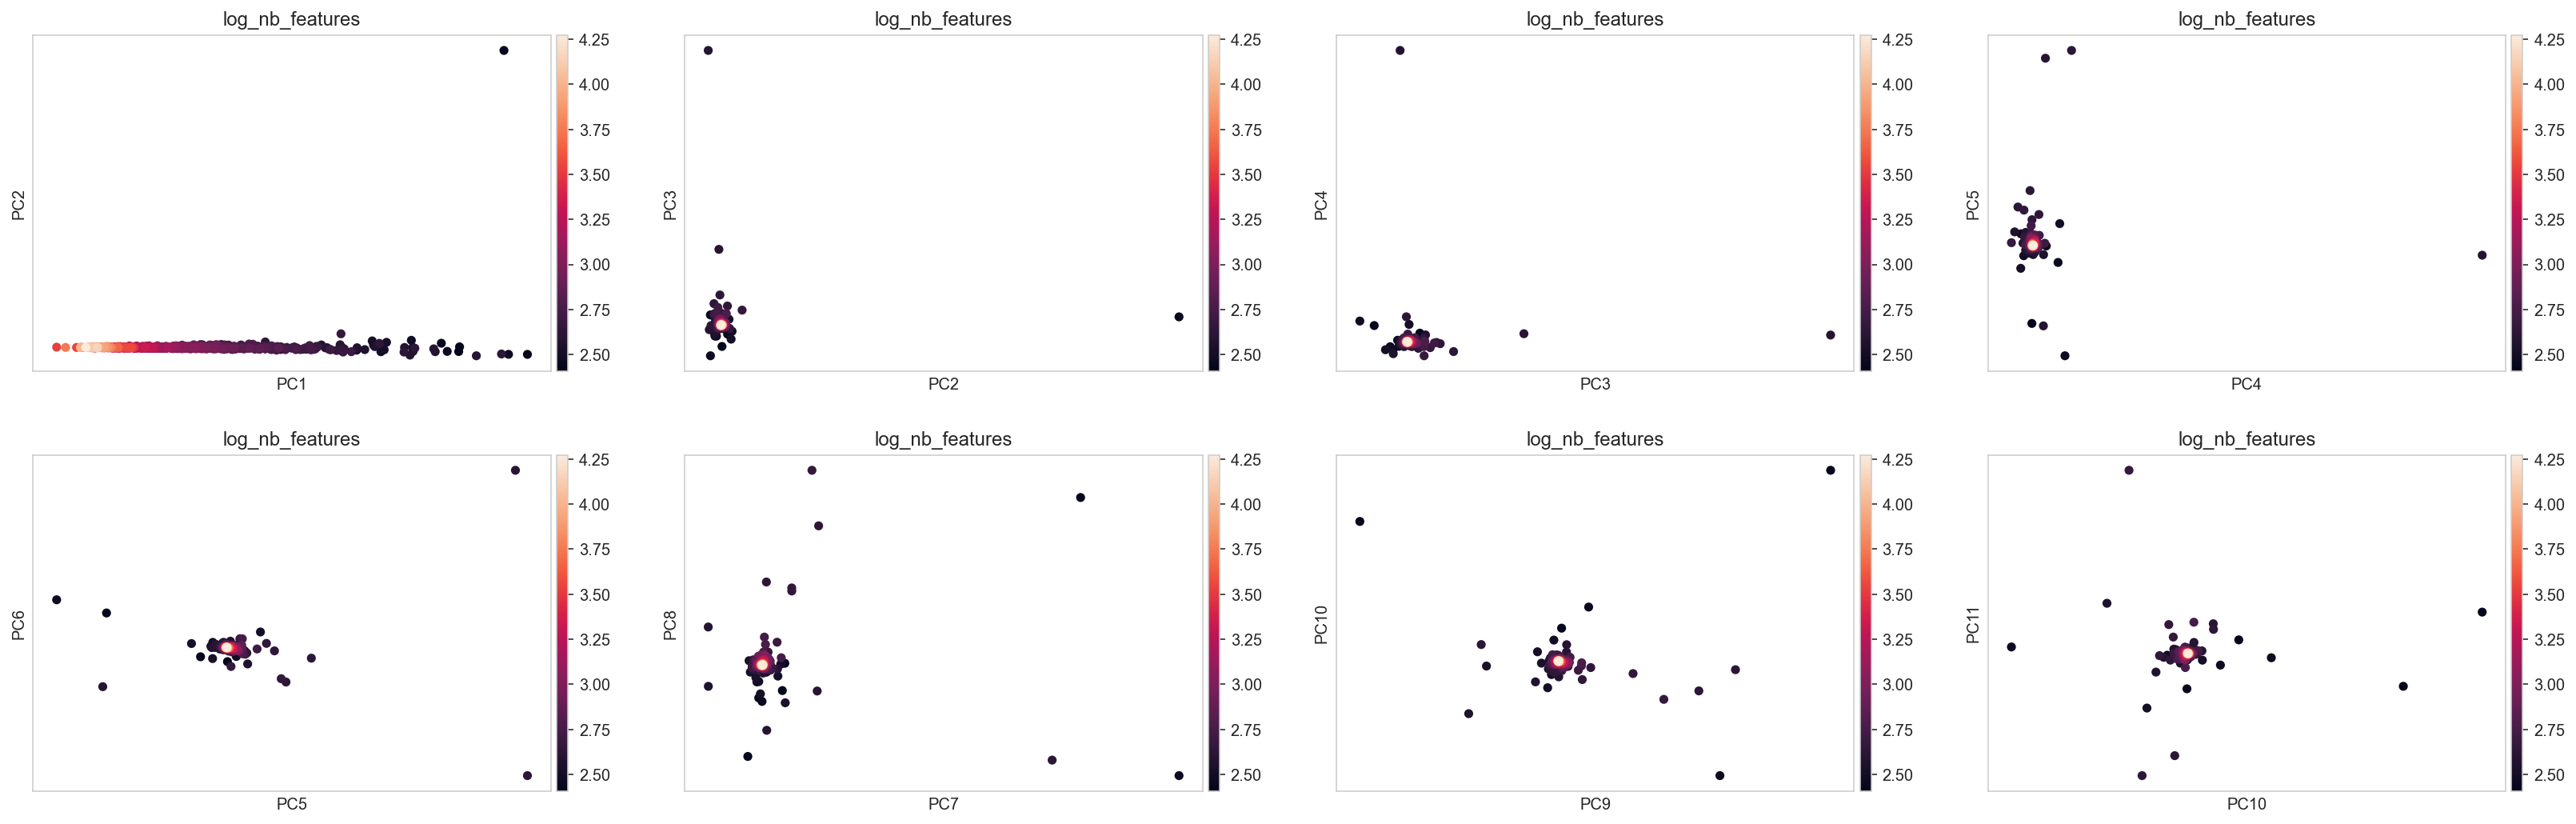

In [41]:
epi.pl.pca(adata, components=['1,2','2,3','3,4','4,5','5,6','7,8','9,10','10,11'], color="log_nb_features")

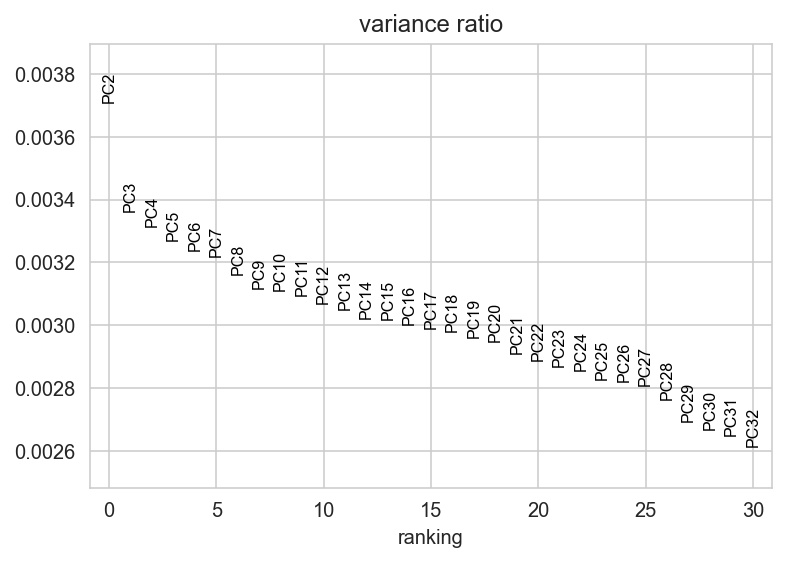

In [49]:
sc.pl.pca_variance_ratio(adata, n_pcs=30)

In [50]:
epi.pp.lazy(adata)

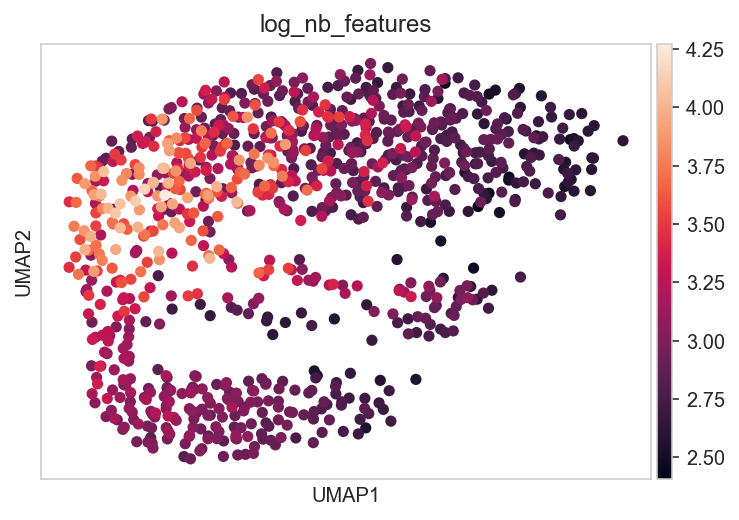

In [51]:
sc.pl.umap(adata, color=["log_nb_features"])

In [52]:
epi.tl.louvain(adata)

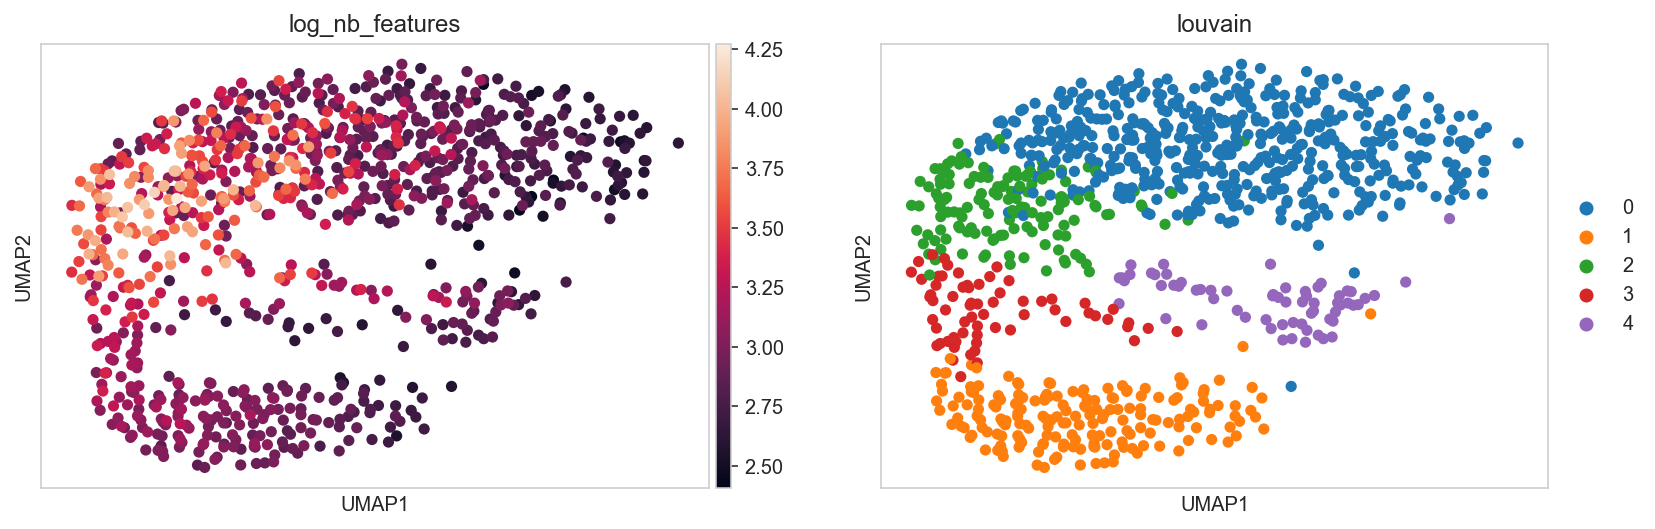

In [53]:
epi.pl.umap(adata, color=["log_nb_features", "louvain"])

In [54]:
adata.var

,n_cells,commonness,prop_shared_cells,variability_score
chr1_775000_780000,8.0,8.0,0.008386,0.508386
chr1_815000_820000,8.0,8.0,0.008386,0.508386
chr1_820000_825000,8.0,8.0,0.008386,0.508386
chr1_1155000_1160000,8.0,8.0,0.008386,0.508386
chr1_1205000_1210000,7.0,7.0,0.007338,0.507338
...,...,...,...,...
chrY_21840000_21845000,6.0,6.0,0.006289,0.506289
chrY_22220000_22225000,9.0,9.0,0.009434,0.509434
chrY_22290000_22295000,5.0,5.0,0.005241,0.505241
chrY_22365000_22370000,9.0,9.0,0.009434,0.509434


In [56]:
np.sort(adata.var["n_cells"])

array([  5.,   5.,   5., ..., 106., 112., 120.])

In [68]:
np.sort(adata.var["n_cells"])[-20000]

18.0

In [69]:
adata_20k = adata[:, adata.var["n_cells"] >= np.sort(adata.var["n_cells"])[-20000]]

In [71]:
epi.pp.lazy(adata_20k)

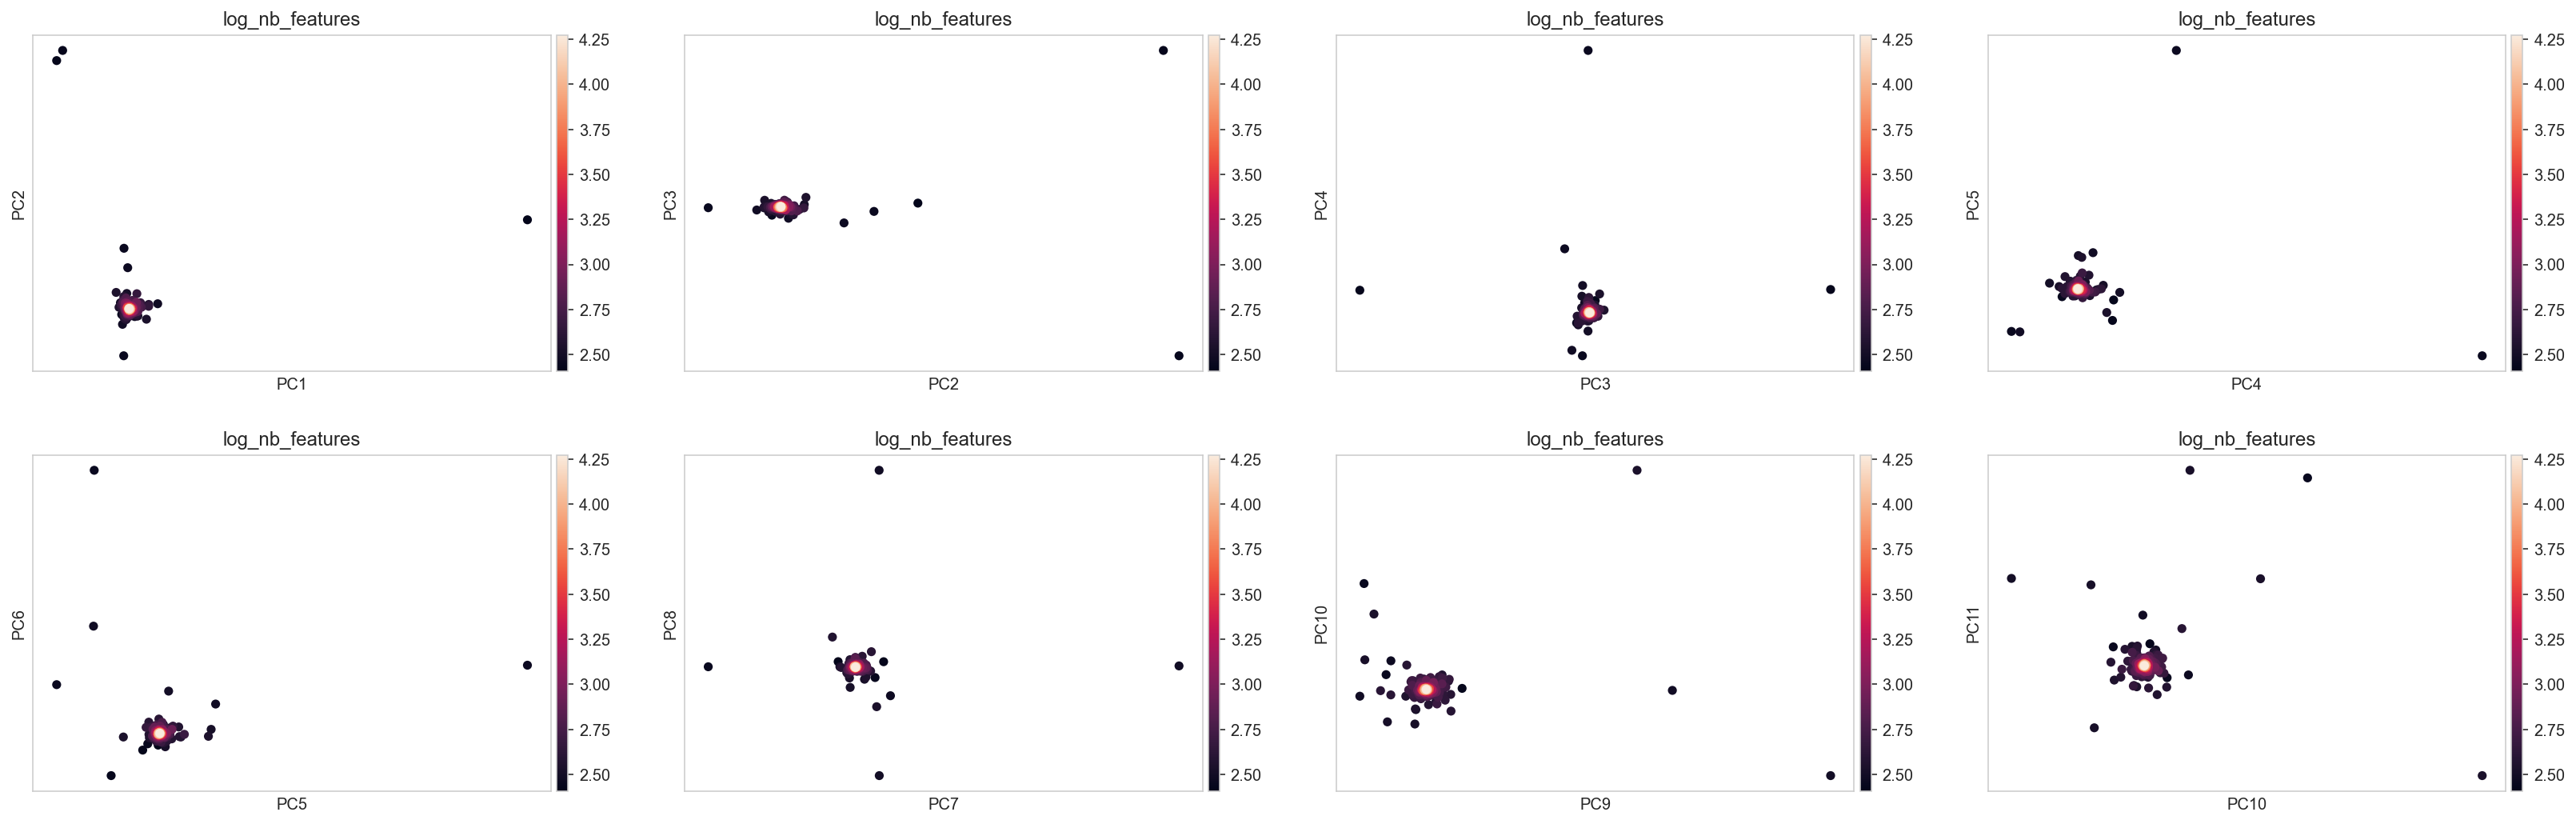

In [74]:
epi.pl.pca(adata_20k, components=['1,2','2,3','3,4','4,5','5,6','7,8','9,10','10,11'], color="log_nb_features")